In [3]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision

import copy
import time

In [4]:
apply_transform = transforms.Compose([
                                    transforms.Resize(32),
                                    transforms.ToTensor()
                                    ])

BatchSize = 100

trainset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [5]:
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

No. of samples in train set: 50000
No. of samples in test set: 10000


In [6]:
class LeNet(nn.Module):

  def __init__(self):

    super(LeNet,self).__init__()

    # mapping 3 input channels to 6 output channels with a kernel size of (5,5) so change of image shape is (1,32,32,3) to (1,28,28,6)

    self.conv1 = nn.Conv2d(3, 6, 5) 

    #Max pooling uses a kernel size of (2,2) with a stride of 2 so that the image changes from (1,28,28,6) to (1,14,14,6)

    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.dense1 = nn.Linear(16 * 5 * 5, 120)
    self.dense2 = nn.Linear(120, 84)
    self.dense3 = nn.Linear(84, 10)

  def forward(self,input):

    x = F.relu(self.conv1(input))
    x = self.pool(x)
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.dense1(x))
    x = F.relu(self.dense2(x))
    x = self.dense3(x)
    return F.log_softmax(x)

In [7]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dense1): Linear(in_features=400, out_features=120, bias=True)
  (dense2): Linear(in_features=120, out_features=84, bias=True)
  (dense3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')   
    net = net.cuda()

GPU is available!


In [9]:
#copying the initial weights for visualization

init_weightConv1 = copy.deepcopy(net.conv1.weight.data)
init_weightConv2 = copy.deepcopy(net.conv2.weight.data)

In [10]:
criterion = nn.NLLLoss() #Negative Log-Likelihood

optimizer = optim.Adam(net.parameters(),lr = 1e-4) #Adam

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 1 /10  ;  Training Loss: 0.021137 ; Testing Acc: 29.410 ; Time consumed: 0m 10s 
Iteration: 2 /10  ;  Training Loss: 0.018646 ; Testing Acc: 34.330 ; Time consumed: 0m 10s 
Iteration: 3 /10  ;  Training Loss: 0.017787 ; Testing Acc: 37.200 ; Time consumed: 0m 10s 
Iteration: 4 /10  ;  Training Loss: 0.016988 ; Testing Acc: 38.810 ; Time consumed: 0m 10s 
Iteration: 5 /10  ;  Training Loss: 0.016438 ; Testing Acc: 41.120 ; Time consumed: 0m 10s 
Iteration: 6 /10  ;  Training Loss: 0.016031 ; Testing Acc: 42.220 ; Time consumed: 0m 10s 
Iteration: 7 /10  ;  Training Loss: 0.015729 ; Testing Acc: 43.380 ; Time consumed: 0m 10s 
Iteration: 8 /10  ;  Training Loss: 0.015495 ; Testing Acc: 44.310 ; Time consumed: 0m 10s 
Iteration: 9 /10  ;  Training Loss: 0.015266 ; Testing Acc: 44.390 ; Time consumed: 0m 10s 
Iteration: 10 /10  ;  Training Loss: 0.015122 ; Testing Acc: 45.360 ; Time consumed: 0m 10s 
Training completed in 1m 42s


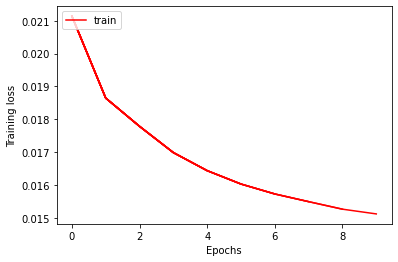

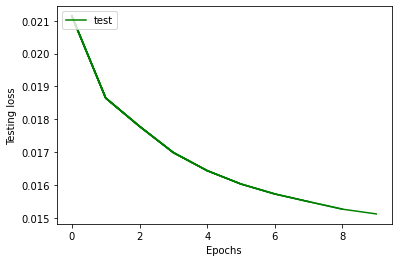

In [11]:
iterations = 10

trainLoss = []

testAcc = []

start = time.time()

for epoch in range(iterations):

  epochstart = time.time()

  running_loss = 0

  net.train(True) #for training

  for data in trainLoader:

    inputs,labels = data

    # Wrap them in Cuda variable
    if use_gpu:

      inputs,labels = Variable(inputs.cuda()) , Variable(labels.cuda())

    else:

      inputs,labels = Variable(inputs) , Variable(labels)


    # Initialize the gradients to zero
    optimizer.zero_grad()

    #Feed forward input data thorugh the network
    outputs = net(inputs)

    #compute loss/error
    loss = criterion(outputs,labels)

    #Backpropagate the loss and compute the gradients
    loss.backward()

    #update the network parameters
    optimizer.step()

    #Accumulate loss per batch
    running_loss += loss.data

  avgTrainLoss = running_loss/50000.0

  trainLoss.append(avgTrainLoss)

  #Evaluating performace on test set for each epoch

  net.train(False)

  running_correct = 0

  for data in testLoader:

    inputs,labels = data

    # Wrap them in Cuda variable

    if use_gpu:
        inputs = Variable(inputs.cuda())
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.to('cpu')
    else:
        inputs = Variable(inputs)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)


    running_correct += (predicted == labels).sum()

  avgTestAcc = running_correct/10000.0

  testAcc.append(avgTestAcc)


  #Plotting training loss vs Epochs

  fig1 = plt.figure(1)

  plt.plot(range(epoch+1),trainLoss,'r-',label = 'train')

  if epoch == 0:

    plt.legend(loc='upper left')
    plt.xlabel('Epochs')
    plt.ylabel('Training loss')


  #Plotting testing loss vs Epochs

  fig1 = plt.figure(2)

  plt.plot(range(epoch+1),trainLoss,'g-',label = 'test')

  if epoch == 0:

    plt.legend(loc='upper left')
    plt.xlabel('Epochs')
    plt.ylabel('Testing loss')

    epochEnd = time.time() - epochstart

  print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc*100,epochEnd//60,epochEnd%60))
  
end = time.time() - start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

  
     






    




In [12]:
#copying the initial weights for visualization

train_weightConv1 = copy.deepcopy(net.conv1.weight.data)
train_weightConv2 = copy.deepcopy(net.conv2.weight.data)

In [13]:
#function to show initial and trained weights

def imshow(img,strlabel):

  npimg = img.cpu().numpy()

  npimg = np.abs(npimg)

  fig_size = plt.rcParams["figure.figsize"]

  fig_size[0] = 10

  fig_size[1] = 10

  plt.rcParams["figure.figsize"] = fig_size

  plt.figure()

  plt.title(strlabel)

  plt.imshow(np.transpose(npimg,(1,2,0)))



RuntimeError: ignored

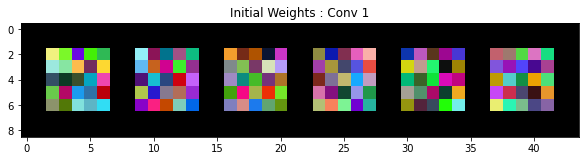

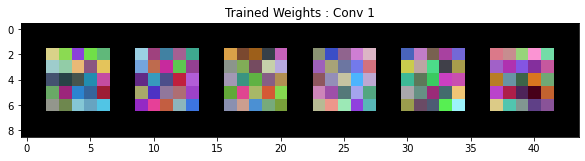

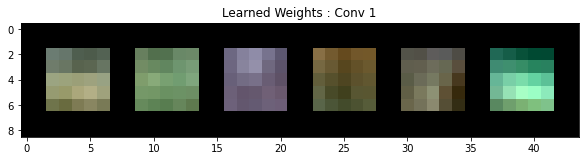

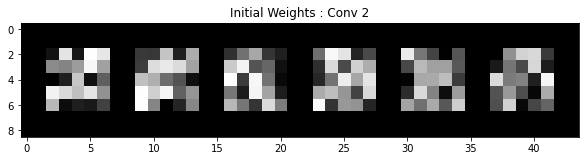

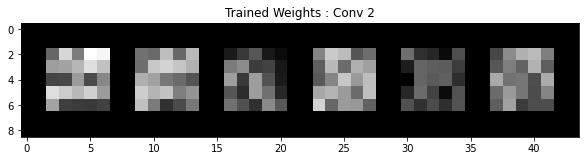

In [14]:
imshow(torchvision.utils.make_grid(init_weightConv1,nrow=6,normalize=True),'Initial Weights : Conv 1')
imshow(torchvision.utils.make_grid(train_weightConv1,nrow=6,normalize=True),'Trained Weights : Conv 1')
imshow(torchvision.utils.make_grid(init_weightConv1.cuda() - train_weightConv1.data,nrow=6,normalize=True),'Learned Weights : Conv 1')

imshow(torchvision.utils.make_grid(init_weightConv2[0].unsqueeze(1),nrow=6,normalize=True),'Initial Weights : Conv 2')
imshow(torchvision.utils.make_grid(train_weightConv2[0].unsqueeze(1),nrow=6,normalize=True),'Trained Weights : Conv 2')
imshow(torchvision.utils.make_grid(init_weightConv2[0].unsqueeze(1).cuda() - train_weightConv1[0].unsqueeze(1),nrow=6,normalize=True),'Learned Weights : Conv 2')